<a href="https://colab.research.google.com/github/sneha5678-cmyk/12-FEB-2025/blob/main/Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing values before preprocessing:
satisfaction                           0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Seat comfort                           0
Departure/Arrival time convenient      0
Food and drink                         0
Gate location                          0
Inflight wifi service                  0
Inflight entertainment                 0
Online support                         0
Ease of Online booking                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Cleanliness                            0
Online boarding                        0
Departure Delay in Minutes             0
Arrival Delay in Minutes             393
dtype: int64

Shape 

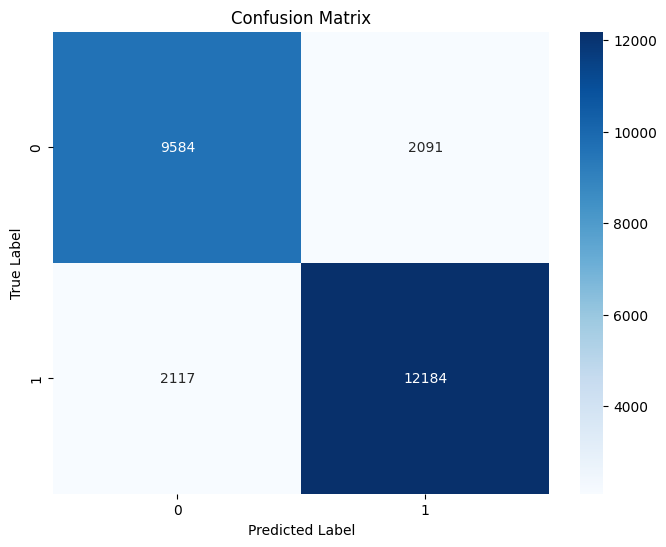

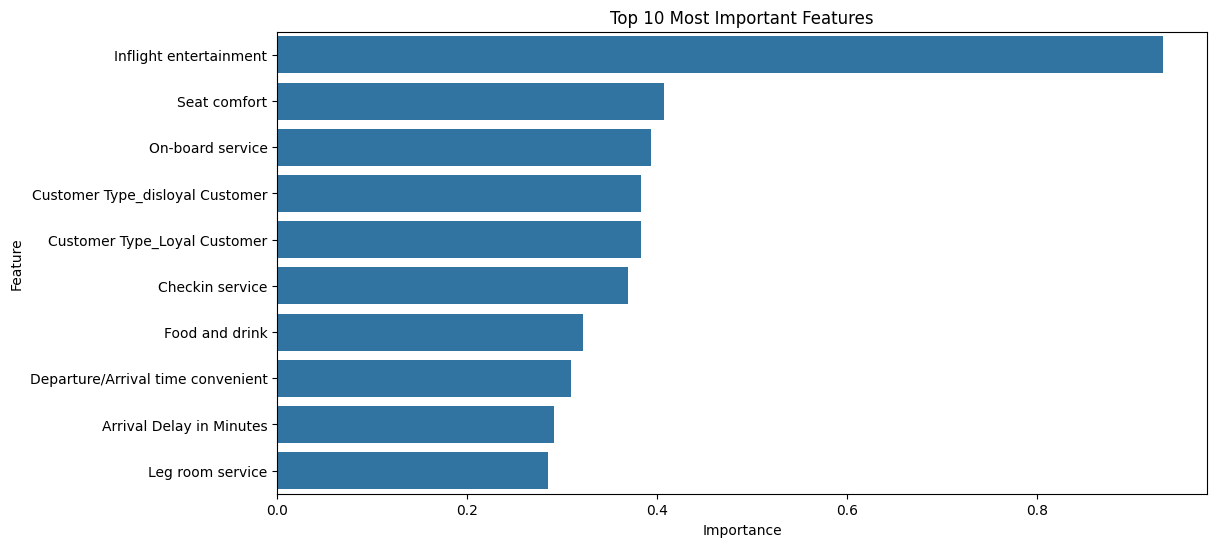


Model Accuracy: 0.8380


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Read the dataset
df = pd.read_csv('/content/Invistico_Airline.csv')

# Check for missing values
print("Missing values before preprocessing:")
print(df.isnull().sum())

# Convert satisfaction to binary (0/1)
le = LabelEncoder()
df['satisfaction_encoded'] = le.fit_transform(df['satisfaction'])

# Convert categorical variables to dummy variables
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Prepare features and target
# Exclude original satisfaction column and other non-numeric columns
X = df_encoded.drop(['satisfaction', 'satisfaction_encoded'], axis=1)
y = df_encoded['satisfaction_encoded']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("\nShape of training data after preprocessing:", X_train_scaled.shape)
print("Shape of testing data after preprocessing:", X_test_scaled.shape)

# Create and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Print model evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(model.coef_[0])
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.show()

# Print model accuracy
print(f"\nModel Accuracy: {model.score(X_test_scaled, y_test):.4f}")

# Save the model and preprocessing objects (optional)
import pickle
with open('airline_satisfaction_model.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats

# Read the dataset
df = pd.read_csv('/content/Invistico_Airline.csv')

# Convert satisfaction to binary (0/1)
le = LabelEncoder()
df['satisfaction_encoded'] = le.fit_transform(df['satisfaction'])

# Convert categorical variables to dummy variables
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)  # drop_first=True for reference categories

# Prepare features and target
X = df_encoded.drop(['satisfaction', 'satisfaction_encoded'], axis=1)
y = df_encoded['satisfaction_encoded']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Add constant for statsmodels
X_with_const = sm.add_constant(X_imputed)

# Fit logistic regression using statsmodels
model = sm.Logit(y, X_with_const)
results = model.fit()

# Calculate Odds Ratios and Confidence Intervals
params = results.params
conf = results.conf_int()
odds_ratios = np.exp(params)
odds_ratios_conf = np.exp(conf)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Variable': params.index,
    'Coefficient': params,
    'Std Error': results.bse,
    'z-value': results.tvalues,
    'P>|z|': results.pvalues,
    'Odds Ratio': odds_ratios,
    '[0.025': odds_ratios_conf[0],
    '0.975]': odds_ratios_conf[1]
})

# Format p-values with stars for significance
def add_stars(p_value):
    if p_value < 0.001:
        return f"{p_value:.4f}***"
    elif p_value < 0.01:
        return f"{p_value:.4f}**"
    elif p_value < 0.05:
        return f"{p_value:.4f}*"
    else:
        return f"{p_value:.4f}"

summary_df['P>|z|'] = summary_df['P>|z|'].apply(add_stars)

# Print model summary similar to Excel/JMP output
print("\n=== Logistic Regression Analysis ===")
print("\nModel Summary:")
print(f"Number of Observations: {len(X_imputed)}")
print(f"Pseudo R-squared: {results.prsquared:.4f}")
print(f"Log-Likelihood: {results.llf:.4f}")
print(f"AIC: {results.aic:.4f}")
print(f"BIC: {results.bic:.4f}")
print(f"Chi-Square: {results.llr:.4f}")
print(f"Chi-Square p-value: {stats.chi2.sf(results.llr, results.df_model):.4f}")

print("\nDetailed Parameter Estimates:")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(summary_df.round(4).to_string())

# Calculate and print classification metrics
y_pred = (results.predict(X_with_const) > 0.5).astype(int)
accuracy = (y == y_pred).mean()
true_pos = ((y == 1) & (y_pred == 1)).sum()
false_pos = ((y == 0) & (y_pred == 1)).sum()
true_neg = ((y == 0) & (y_pred == 0)).sum()
false_neg = ((y == 1) & (y_pred == 0)).sum()

print("\nClassification Summary:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (True Positive Rate): {true_pos/(true_pos + false_neg):.4f}")
print(f"Specificity (True Negative Rate): {true_neg/(true_neg + false_pos):.4f}")
print(f"Positive Predictive Value: {true_pos/(true_pos + false_pos):.4f}")
print(f"Negative Predictive Value: {true_neg/(true_neg + false_neg):.4f}")

# Print interpretation note
print("\nNote:")
print("* p < 0.05")
print("** p < 0.01")
print("*** p < 0.001")
print("\nInterpretation:")
print("- Odds Ratio > 1: Positive association with satisfaction")
print("- Odds Ratio < 1: Negative association with satisfaction")
print("- Coefficient represents the log odds")

Optimization terminated successfully.
         Current function value: 0.384903
         Iterations 7

=== Logistic Regression Analysis ===

Model Summary:
Number of Observations: 129880
Pseudo R-squared: 0.4411
Log-Likelihood: -49991.2038
AIC: 100030.4076
BIC: 100264.9924
Chi-Square: 78904.0516
Chi-Square p-value: 0.0000

Detailed Parameter Estimates:
                                                            Variable  Coefficient  Std Error  z-value      P>|z|  Odds Ratio  [0.025  0.975]
const                                                          const      -4.8182     0.0624 -77.2516  0.0000***      0.0081  0.0072  0.0091
Age                                                              Age      -0.0078     0.0006 -13.5790  0.0000***      0.9923  0.9912  0.9934
Flight Distance                                      Flight Distance      -0.0001     0.0000 -12.8842  0.0000***      0.9999  0.9999  0.9999
Seat comfort                                            Seat comfort       0.2896

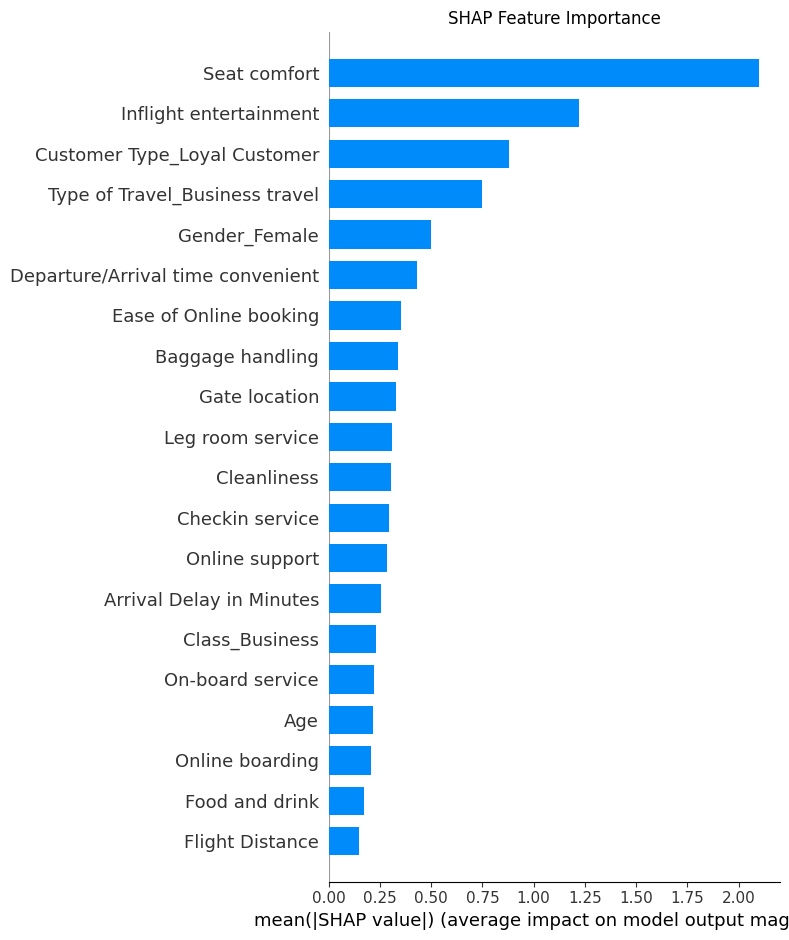

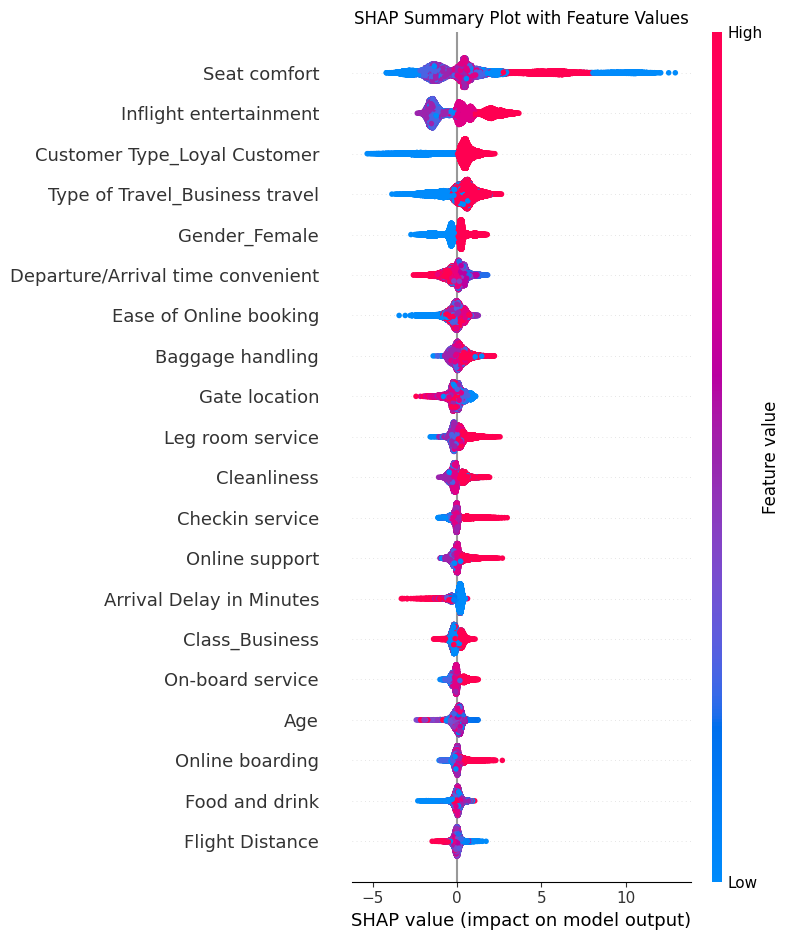

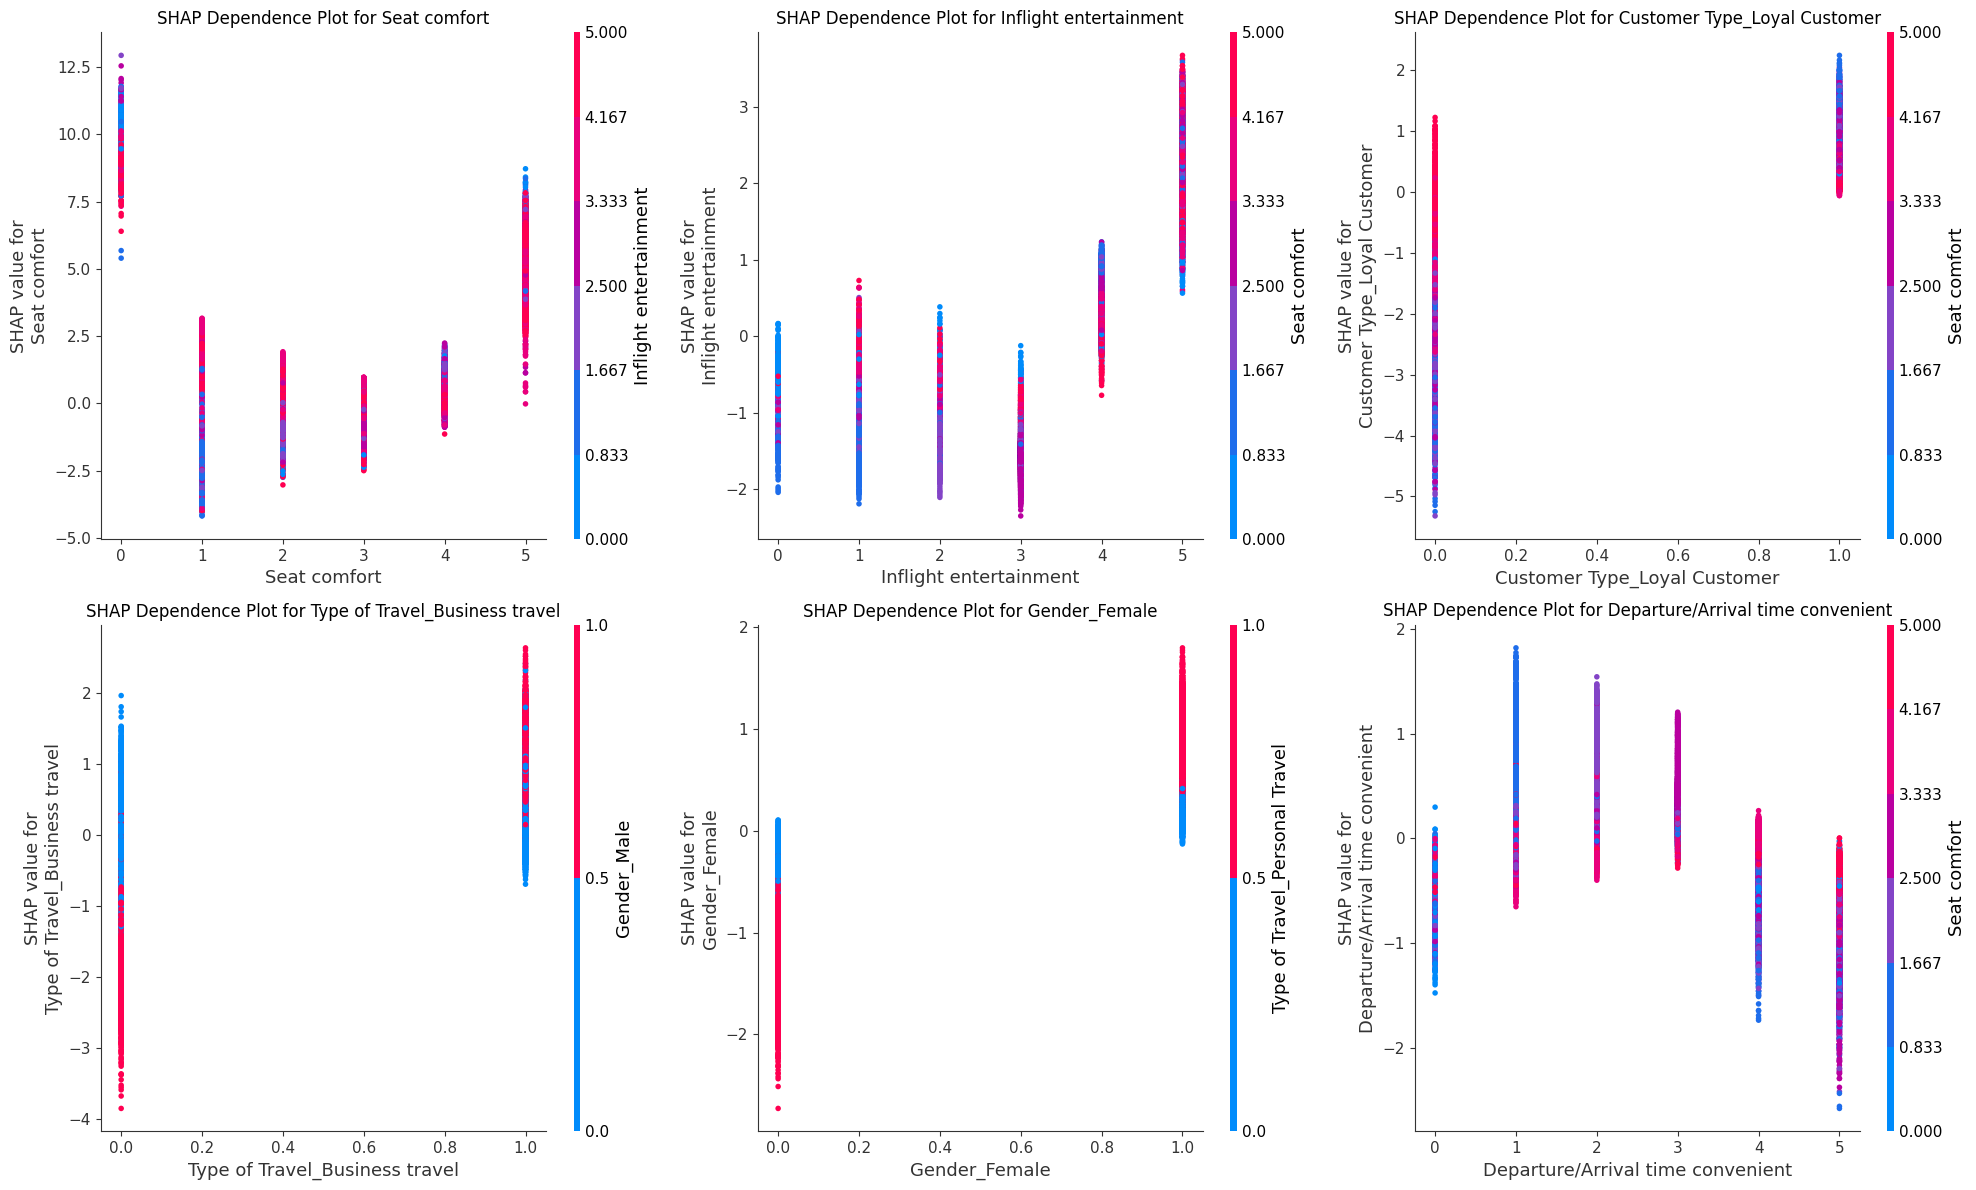

<Figure size 2000x300 with 0 Axes>

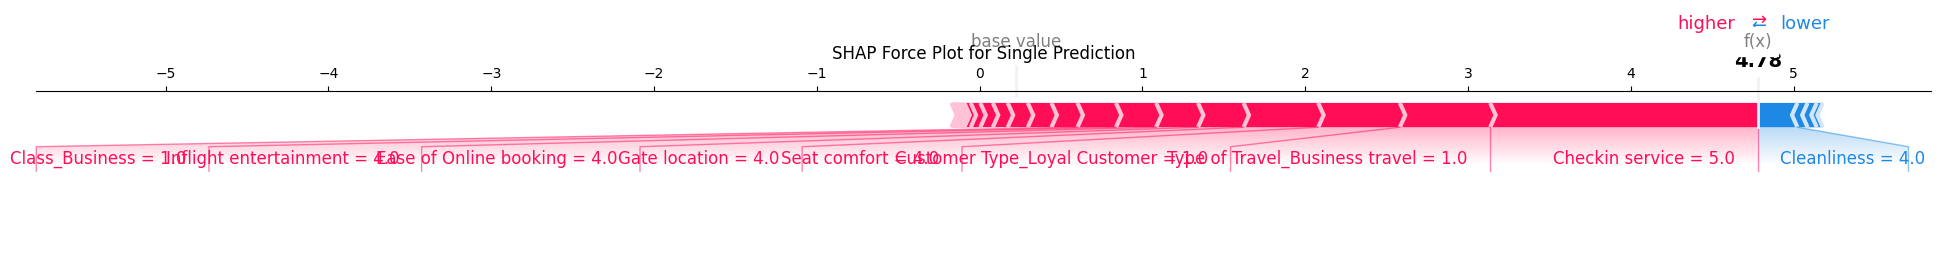


Feature Importance Summary:
                          Feature  SHAP_importance
                     Seat comfort         2.097627
           Inflight entertainment         1.218844
     Customer Type_Loyal Customer         0.879820
   Type of Travel_Business travel         0.746310
                    Gender_Female         0.499520
Departure/Arrival time convenient         0.429794
           Ease of Online booking         0.352882
                 Baggage handling         0.337958
                    Gate location         0.327841
                 Leg room service         0.309240
                      Cleanliness         0.301557
                  Checkin service         0.296020
                   Online support         0.284455
         Arrival Delay in Minutes         0.255901
                   Class_Business         0.230168
                 On-board service         0.220311
                              Age         0.214054
                  Online boarding         0.205199
  

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Read and preprocess the data
def preprocess_data(df):
    # Convert satisfaction to binary
    le = LabelEncoder()
    df['satisfaction_encoded'] = le.fit_transform(df['satisfaction'])

    # Convert categorical variables to dummy variables
    categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Prepare features and target
    X = df_encoded.drop(['satisfaction', 'satisfaction_encoded'], axis=1)
    y = df_encoded['satisfaction_encoded']

    return X, y

# Load the data
df = pd.read_csv('/content/Invistico_Airline.csv')
X, y = preprocess_data(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Train XGBoost model (SHAP works particularly well with tree-based models)
model = xgb.XGBClassifier(random_state=42)
model.fit(X_train_imputed, y_train)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_imputed)

# If shap_values is a list, take the first element (for binary classification)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Plot 1: Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_imputed, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Plot 2: Detailed Summary Plot with Feature Values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_imputed, show=False)
plt.title("SHAP Summary Plot with Feature Values")
plt.tight_layout()
plt.show()

# Plot 3: SHAP Dependence Plots for top 6 features
# Get the mean absolute SHAP value for each feature
feature_importance = np.abs(shap_values).mean(0)
most_important_features = pd.Series(feature_importance, index=X_test_imputed.columns).nlargest(6).index

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(most_important_features):
    plt.sca(axes[idx])
    shap.dependence_plot(
        feature,
        shap_values,
        X_test_imputed,
        show=False,
        ax=axes[idx]
    )
    axes[idx].set_title(f"SHAP Dependence Plot for {feature}")

plt.tight_layout()
plt.show()

# Plot 4: SHAP Force Plot for a single prediction
plt.figure(figsize=(20, 3))
shap.force_plot(
    explainer.expected_value,
    shap_values[0,:],
    X_test_imputed.iloc[0,:],
    show=False,
    matplotlib=True
)
plt.title("SHAP Force Plot for Single Prediction")
plt.tight_layout()
plt.show()

# Generate and print feature importance summary
feature_importance_df = pd.DataFrame({
    'Feature': X_test_imputed.columns,
    'SHAP_importance': np.abs(shap_values).mean(0)
})
feature_importance_df = feature_importance_df.sort_values('SHAP_importance', ascending=False)

print("\nFeature Importance Summary:")
print(feature_importance_df.to_string(index=False))

# Calculate and print some statistics about the SHAP values
print("\nSHAP Value Statistics:")
shap_stats = pd.DataFrame({
    'Feature': X_test_imputed.columns,
    'Mean_SHAP': np.mean(shap_values, axis=0),
    'Abs_Mean_SHAP': np.mean(np.abs(shap_values), axis=0),
    'Max_SHAP': np.max(shap_values, axis=0),
    'Min_SHAP': np.min(shap_values, axis=0)
})
shap_stats = shap_stats.sort_values('Abs_Mean_SHAP', ascending=False)
print(shap_stats.round(4).to_string(index=False))

# Save the SHAP analysis results
results = {
    'feature_importance': feature_importance_df,
    'shap_stats': shap_stats
}

# Save results to CSV
feature_importance_df.to_csv('shap_feature_importance.csv', index=False)
shap_stats.to_csv('shap_statistics.csv', index=False)

In [ ]:
!pip install numpy pandas sklearn matplotlib seaborn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

class ShapleyValueAnalysis:
    def __init__(self, model, X, feature_names):
        self.model = model
        self.X = X
        self.feature_names = feature_names
        self.n_features = len(feature_names)

    def _get_all_subsets(self):
        """Generate all possible feature subsets"""
        subsets = []
        for i in range(self.n_features + 1):
            subsets.extend(list(combinations(range(self.n_features), i)))
        return subsets

    def _marginal_contribution(self, subset, feature_idx, instance):
        """Calculate marginal contribution of a feature for a given subset"""
        # Create subset with and without the feature
        subset = list(subset)
        if feature_idx in subset:
            return 0

        # Calculate value with feature
        subset_with = subset + [feature_idx]
        X_with = np.zeros((1, self.n_features))
        for idx in subset_with:
            X_with[0, idx] = instance[idx]
        value_with = self.model.predict_proba(X_with)[0][1]

        # Calculate value without feature
        X_without = np.zeros((1, self.n_features))
        for idx in subset:
            X_without[0, idx] = instance[idx]
        value_without = self.model.predict_proba(X_without)[0][1]

        return value_with - value_without

    def calculate_shapley_values(self, instance):
        """Calculate Shapley values for all features for a given instance"""
        shapley_values = np.zeros(self.n_features)
        subsets = self._get_all_subsets()

        for feature_idx in range(self.n_features):
            value = 0
            for subset in subsets:
                if feature_idx not in subset:
                    subset_size = len(subset)
                    weight = (factorial(subset_size) * factorial(self.n_features - subset_size - 1) /
                            factorial(self.n_features))
                    value += weight * self._marginal_contribution(subset, feature_idx, instance)
            shapley_values[feature_idx] = value

        return shapley_values

def factorial(n):
    if n == 0:
        return 1
    return n * factorial(n-1)

# Load and preprocess data
print("Loading and preprocessing data...")
df = pd.read_csv('/content/Invistico_Airline.csv')

# Convert satisfaction to binary
le = LabelEncoder()
df['satisfaction_encoded'] = le.fit_transform(df['satisfaction'])

# Convert categorical variables to dummy variables
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Prepare features and target
X = df_encoded.drop(['satisfaction', 'satisfaction_encoded'], axis=1)
y = df_encoded['satisfaction_encoded']

# Handle missing values
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

# Train a Random Forest model
print("Training Random Forest model...")
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# Initialize Shapley Analysis
print("Calculating Shapley values...")
shapley_analyzer = ShapleyValueAnalysis(model, X_scaled, X_scaled.columns)

# Calculate Shapley values for a sample of instances
n_samples = 50  # Number of instances to analyze
sample_indices = np.random.choice(len(X_scaled), n_samples, replace=False)
all_shapley_values = []

for idx in sample_indices:
    instance = X_scaled.iloc[idx].values
    shapley_values = shapley_analyzer.calculate_shapley_values(instance)
    all_shapley_values.append(shapley_values)

shapley_df = pd.DataFrame(all_shapley_values, columns=X_scaled.columns)

# Calculate average absolute Shapley values
avg_shapley = np.abs(shapley_df).mean()
sorted_features = avg_shapley.sort_values(ascending=False)

# Visualization 1: Bar plot of average absolute Shapley values
plt.figure(figsize=(12, 6))
sorted_features.plot(kind='bar')
plt.title('Average Absolute Shapley Values by Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 2: Boxplot of Shapley values distribution
plt.figure(figsize=(12, 6))
shapley_df[sorted_features.index[:10]].boxplot(vert=False)
plt.title('Distribution of Shapley Values (Top 10 Features)')
plt.xlabel('Shapley Value')
plt.tight_layout()
plt.show()

# Visualization 3: Heatmap of Shapley values
plt.figure(figsize=(12, 8))
sns.heatmap(shapley_df[sorted_features.index[:10]].T,
            cmap='RdBu',
            center=0,
            xticklabels=False)
plt.title('Heatmap of Shapley Values (Top 10 Features)')
plt.ylabel('Features')
plt.xlabel('Instances')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nShapley Value Summary Statistics:")
summary_stats = shapley_df.agg(['mean', 'std', 'min', 'max']).round(4)
print(summary_stats.sort_values('mean', key=abs, ascending=False))

# Save results
results_df = pd.DataFrame({
    'Feature': sorted_features.index,
    'Average_Absolute_Shapley_Value': sorted_features.values,
    'Mean_Shapley_Value': shapley_df.mean(),
    'Std_Shapley_Value': shapley_df.std()
})

print("\nTop 10 Most Important Features by Shapley Values:")
print(results_df.head(10).to_string(index=False))

# Save results to CSV
results_df.to_csv('shapley_analysis_results.csv', index=False)
shapley_df.to_csv('shapley_values_all_instances.csv', index=False)

Loading and preprocessing data...
Training Random Forest model...
Calculating Shapley values...


Loading and preprocessing data...
Training Random Forest model...
Calculating Shapley values...
Processing instance 1/100
Processing instance 11/100
Processing instance 21/100
Processing instance 31/100
Processing instance 41/100
Processing instance 51/100
Processing instance 61/100
Processing instance 71/100
Processing instance 81/100
Processing instance 91/100


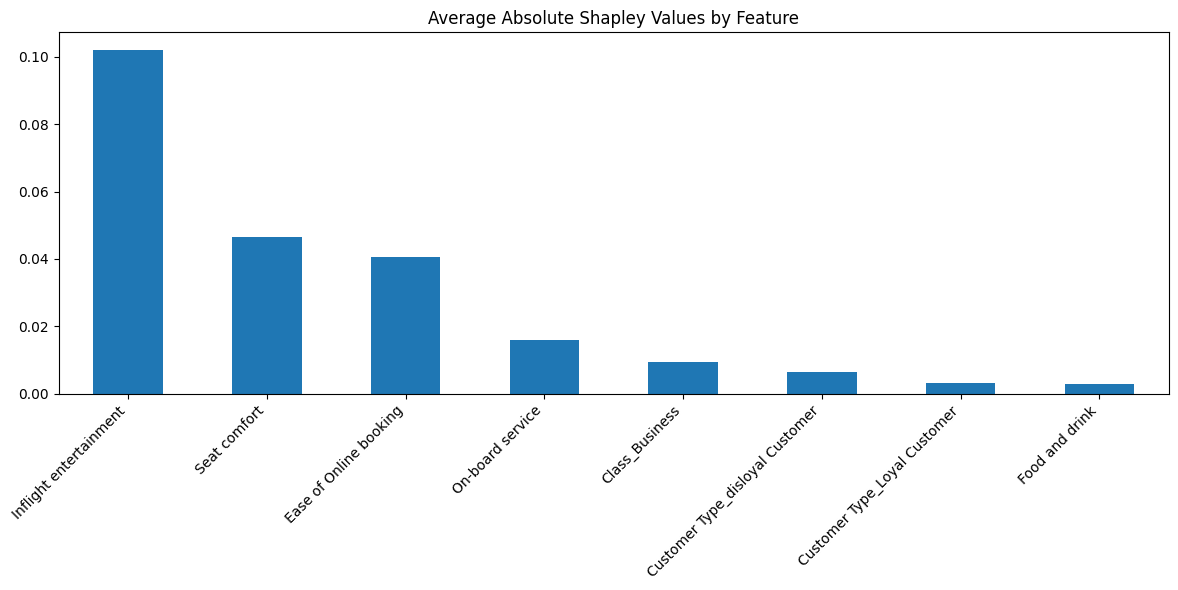

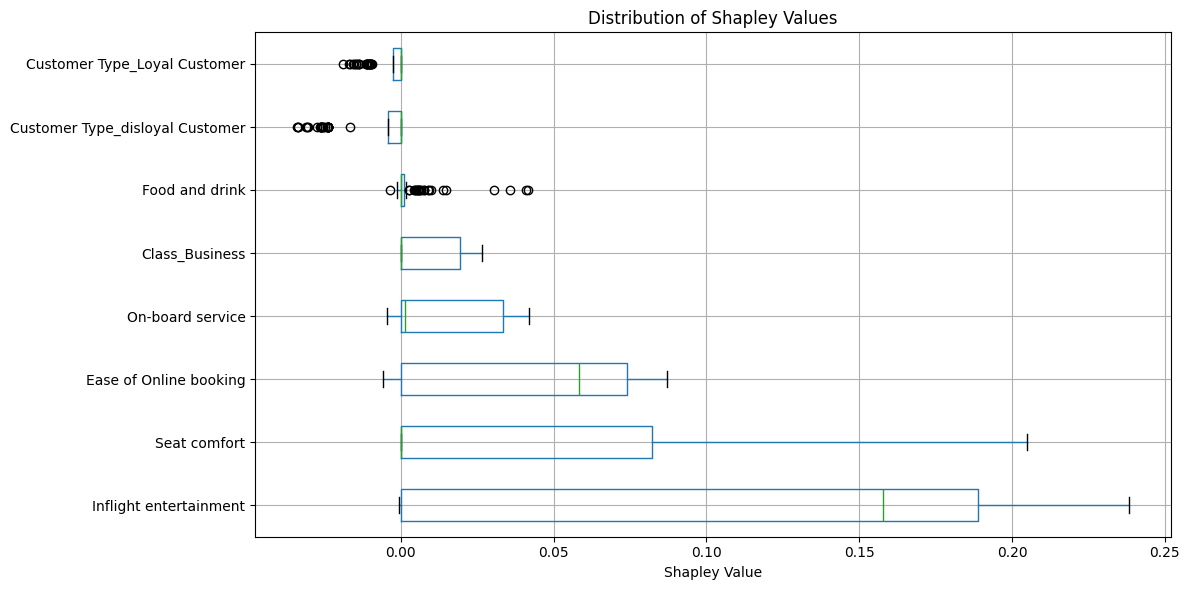


Shapley Value Summary Statistics:
An error occurred: 'mean'
Please try reducing the number of features or sample size if the error persists.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

def calculate_shapley_values_optimized(model, X, feature_names, max_features=10):
    """
    Calculate Shapley values for a limited number of most important features
    """
    # Get feature importances from Random Forest to select top features
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    top_features = importances.head(max_features)['feature'].tolist()
    feature_indices = [list(feature_names).index(f) for f in top_features]

    n_features = len(top_features)
    shapley_values = np.zeros((len(X), n_features))

    def marginal_contribution(subset, feature_idx, instance):
        mask = np.zeros(len(feature_names))
        mask[list(subset)] = 1

        # Create two copies of the instance
        X_with = np.zeros((1, len(feature_names)))
        X_without = np.zeros((1, len(feature_names)))

        # Set values for the subset
        for idx in subset:
            X_with[0, idx] = instance[idx]
            X_without[0, idx] = instance[idx]

        # Add the feature to X_with
        X_with[0, feature_idx] = instance[feature_idx]

        # Calculate probabilities
        prob_with = model.predict_proba(X_with)[0][1]
        prob_without = model.predict_proba(X_without)[0][1]

        return prob_with - prob_without

    # Calculate Shapley values for each instance
    for i in range(len(X)):
        if i % 10 == 0:
            print(f"Processing instance {i+1}/{len(X)}")

        instance = X[i]

        for j, feature_idx in enumerate(feature_indices):
            value = 0
            n_subsets = 0

            # Only consider subsets up to size 3 to reduce computation
            for subset_size in range(min(4, n_features)):
                for subset in combinations(
                    [idx for idx in feature_indices if idx != feature_idx],
                    subset_size
                ):
                    weight = 1 / (n_features * len(list(combinations(range(n_features-1), subset_size))))
                    value += weight * marginal_contribution(subset, feature_idx, instance)
                    n_subsets += 1

            shapley_values[i, j] = value

    return shapley_values, top_features

# Load and preprocess data
print("Loading and preprocessing data...")
try:
    df = pd.read_csv('/content/Invistico_Airline.csv')

    # Convert satisfaction to binary
    le = LabelEncoder()
    df['satisfaction_encoded'] = le.fit_transform(df['satisfaction'])

    # Select important numerical features to reduce dimensionality
    numerical_features = [
        'Age', 'Flight Distance', 'Departure Delay in Minutes',
        'Arrival Delay in Minutes', 'Inflight wifi service',
        'Ease of Online booking', 'Food and drink', 'Seat comfort',
        'Inflight entertainment', 'On-board service'
    ]

    # Convert only essential categorical variables
    categorical_features = ['Class', 'Customer Type']
    df_encoded = pd.get_dummies(df[numerical_features + categorical_features + ['satisfaction_encoded']],
                              columns=categorical_features)

    # Prepare features and target
    X = df_encoded.drop('satisfaction_encoded', axis=1)
    y = df_encoded['satisfaction_encoded']

    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # Scale features
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

    # Train a Random Forest model
    print("Training Random Forest model...")
    model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    model.fit(X_scaled, y)

    # Calculate Shapley values for a sample of instances
    n_samples = 100  # Analyze 100 random instances
    sample_indices = np.random.choice(len(X_scaled), n_samples, replace=False)
    X_sample = X_scaled.iloc[sample_indices].values

    print("Calculating Shapley values...")
    shapley_values, selected_features = calculate_shapley_values_optimized(
        model, X_sample, X_scaled.columns, max_features=8
    )

    # Create DataFrame with Shapley values
    shapley_df = pd.DataFrame(shapley_values, columns=selected_features)

    # Visualization 1: Bar plot of average absolute Shapley values
    plt.figure(figsize=(12, 6))
    abs_means = np.abs(shapley_df).mean().sort_values(ascending=False)
    abs_means.plot(kind='bar')
    plt.title('Average Absolute Shapley Values by Feature')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Visualization 2: Boxplot of Shapley values
    plt.figure(figsize=(12, 6))
    shapley_df.boxplot(vert=False)
    plt.title('Distribution of Shapley Values')
    plt.xlabel('Shapley Value')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nShapley Value Summary Statistics:")
    summary_stats = shapley_df.agg(['mean', 'std', 'min', 'max']).round(4)
    print(summary_stats.sort_values('mean', key=abs, ascending=False))

    # Save results
    results_df = pd.DataFrame({
        'Feature': selected_features,
        'Average_Absolute_Shapley_Value': abs_means.values,
        'Mean_Shapley_Value': shapley_df.mean(),
        'Std_Shapley_Value': shapley_df.std()
    })

    print("\nFeature Importance Ranking:")
    print(results_df.sort_values('Average_Absolute_Shapley_Value', ascending=False).to_string(index=False))

    # Save results to CSV
    results_df.to_csv('shapley_analysis_results.csv', index=False)
    shapley_df.to_csv('shapley_values_all_instances.csv', index=False)

except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Please try reducing the number of features or sample size if the error persists.")